# Exercise 19: Classification of galaxies vs quasars

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

---

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination
from astroML.utils import pickle_results

import corner

%config InlineBackend.figure_format='retina'

In [2]:
file = '../solutions/galaxyquasar.csv'
data_csv = np.genfromtxt(file, delimiter=',', usecols=(0,1,2,3,4,5), dtype = str)
print(data_csv)

[['u' 'g' 'r' 'i' 'z' 'class']
 ['18.97213' '18.53676' '18.5828' '18.34936' '18.29215' 'QSO']
 ['19.24592' '17.47646' '16.47817' '16.04472' '15.68851' 'GALAXY']
 ...
 ['18.62718' '17.30876' '16.87371' '16.62399' '16.42296' 'GALAXY']
 ['19.5514' '18.27711' '17.62101' '17.21947' '17.03347' 'GALAXY']
 ['18.80772' '17.75751' '17.405' '17.2165' '17.12295' 'GALAXY']]


In [3]:
lab = np.char.replace(data_csv[1:,5], 'GALAXY', '0')
lab = np.char.replace(lab, 'QSO', '1').astype(int)

ug = data_csv[1:,0].astype(float) - data_csv[1:,1].astype(float)
gr = data_csv[1:,1].astype(float) - data_csv[1:,2].astype(float)
ri = data_csv[1:,2].astype(float) - data_csv[1:,3].astype(float)
iz = data_csv[1:,3].astype(float) - data_csv[1:,4].astype(float)

data = np.column_stack((ug,gr,ri,iz))

galaxies = data[: , :4][lab==1].astype(float)
quasars = data[: , :4][lab==0].astype(float)

First we check the distribution of the features

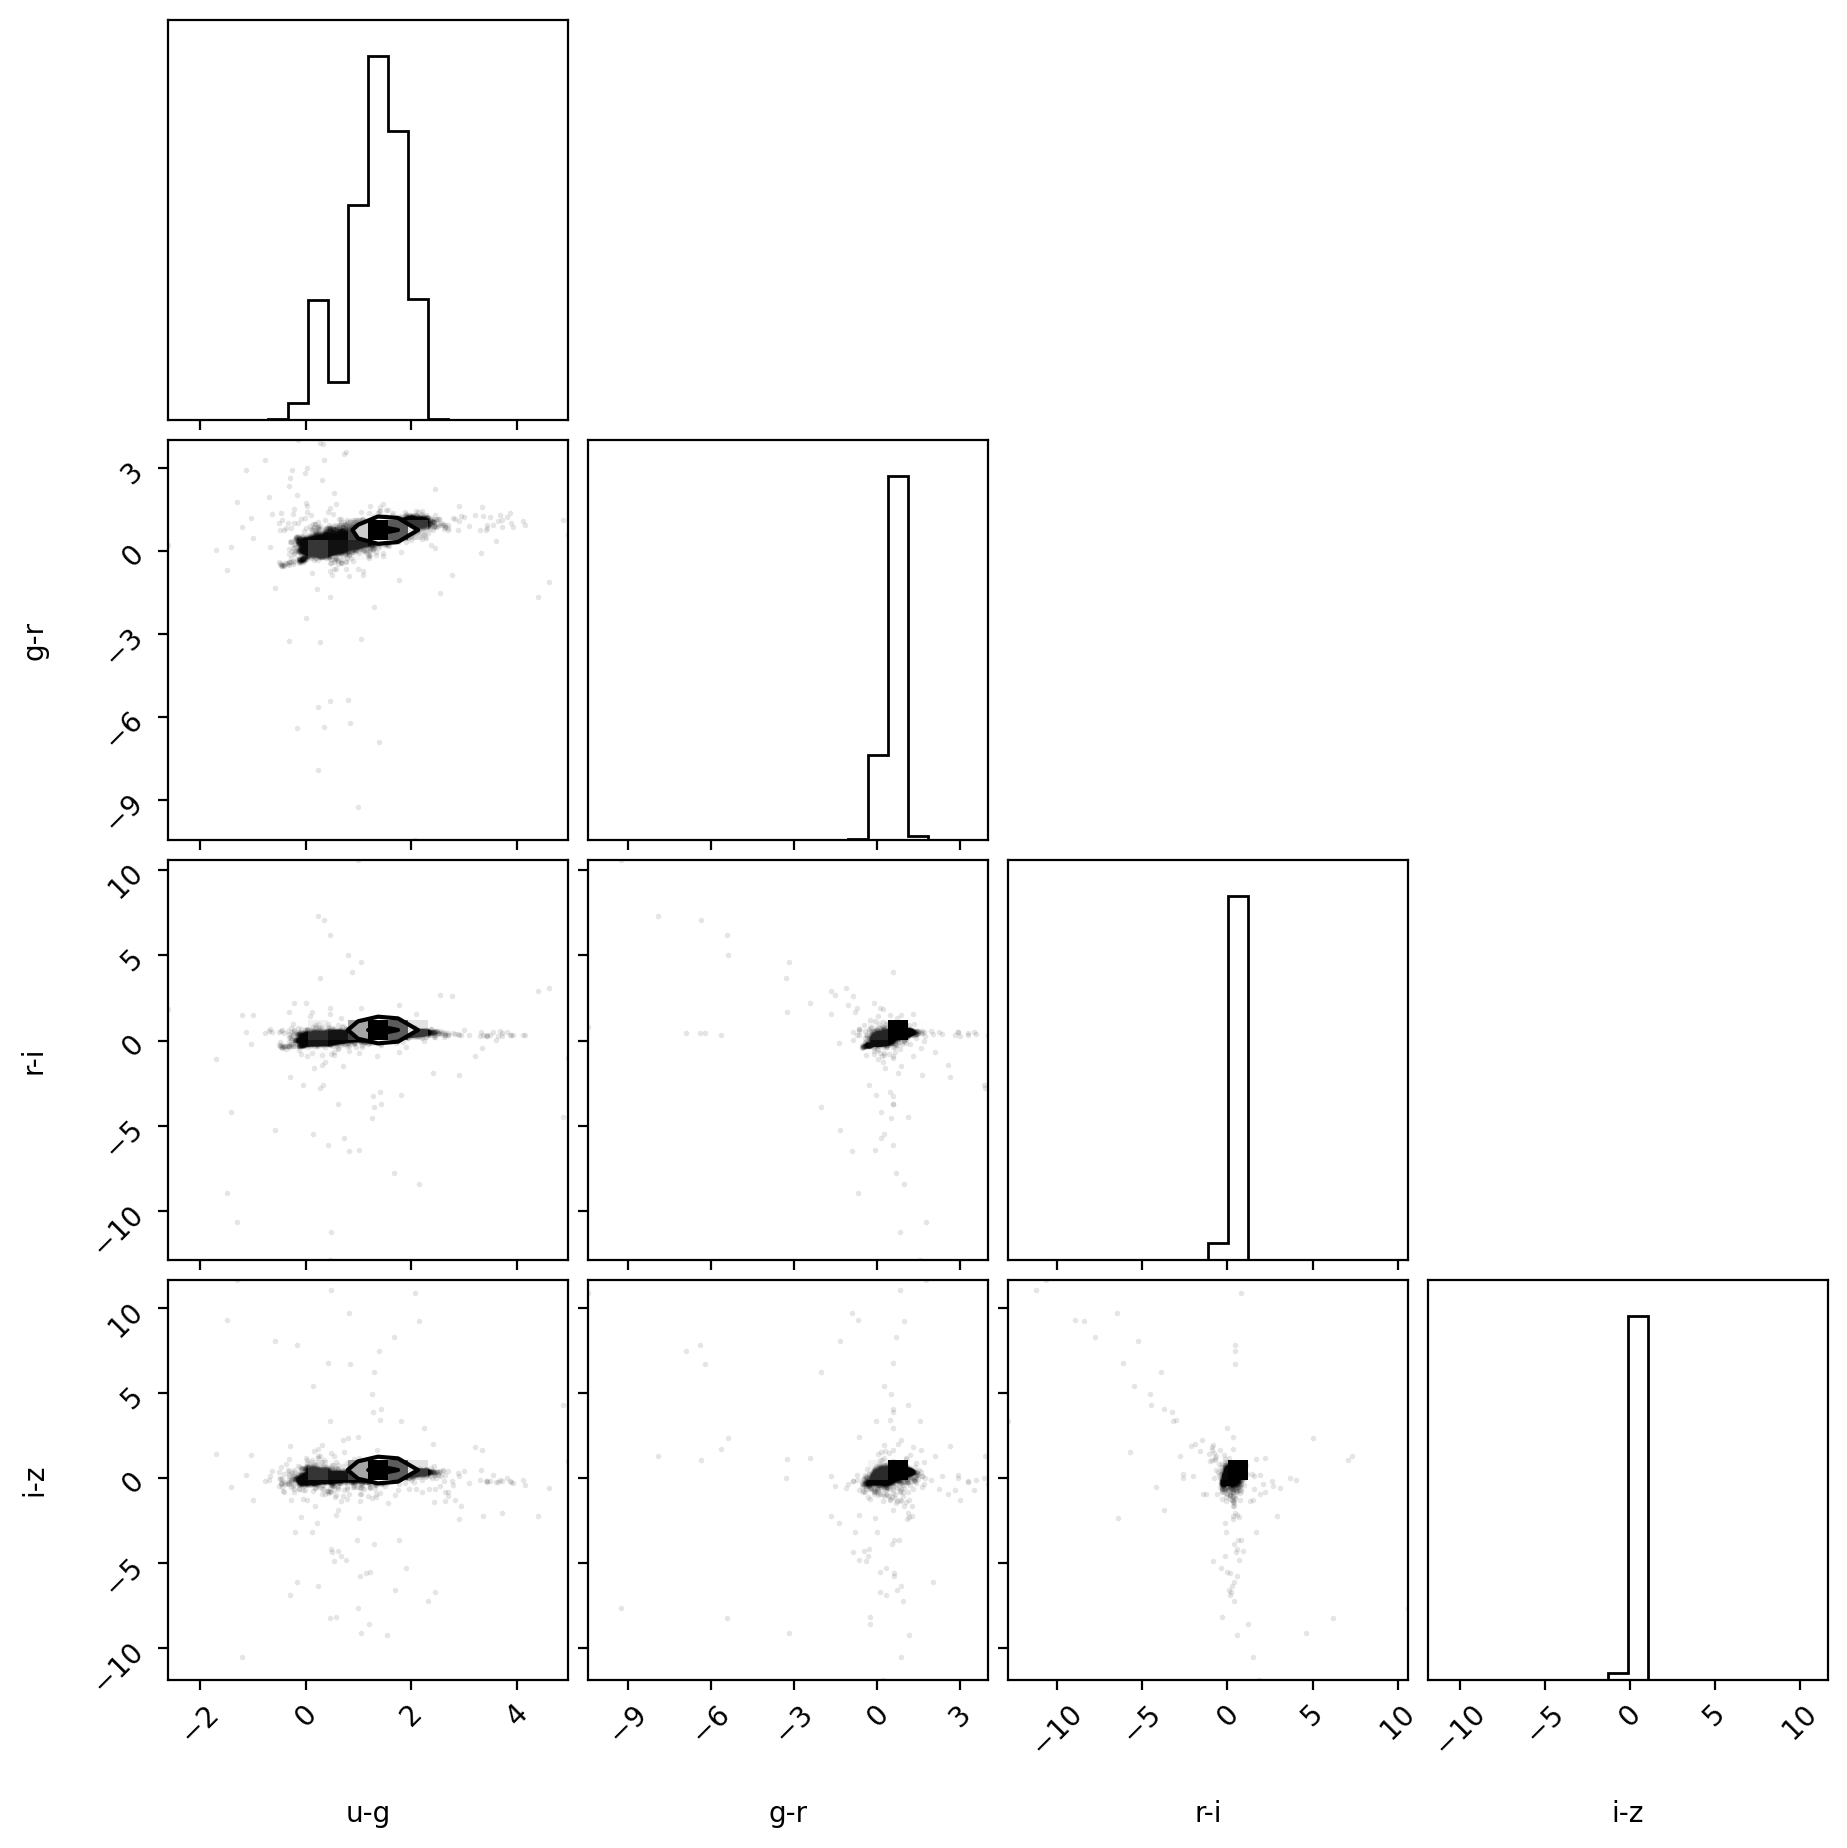

In [4]:
names = ['u-g', 'g-r', 'r-i', 'i-z']
corner.corner(data, labels = names);

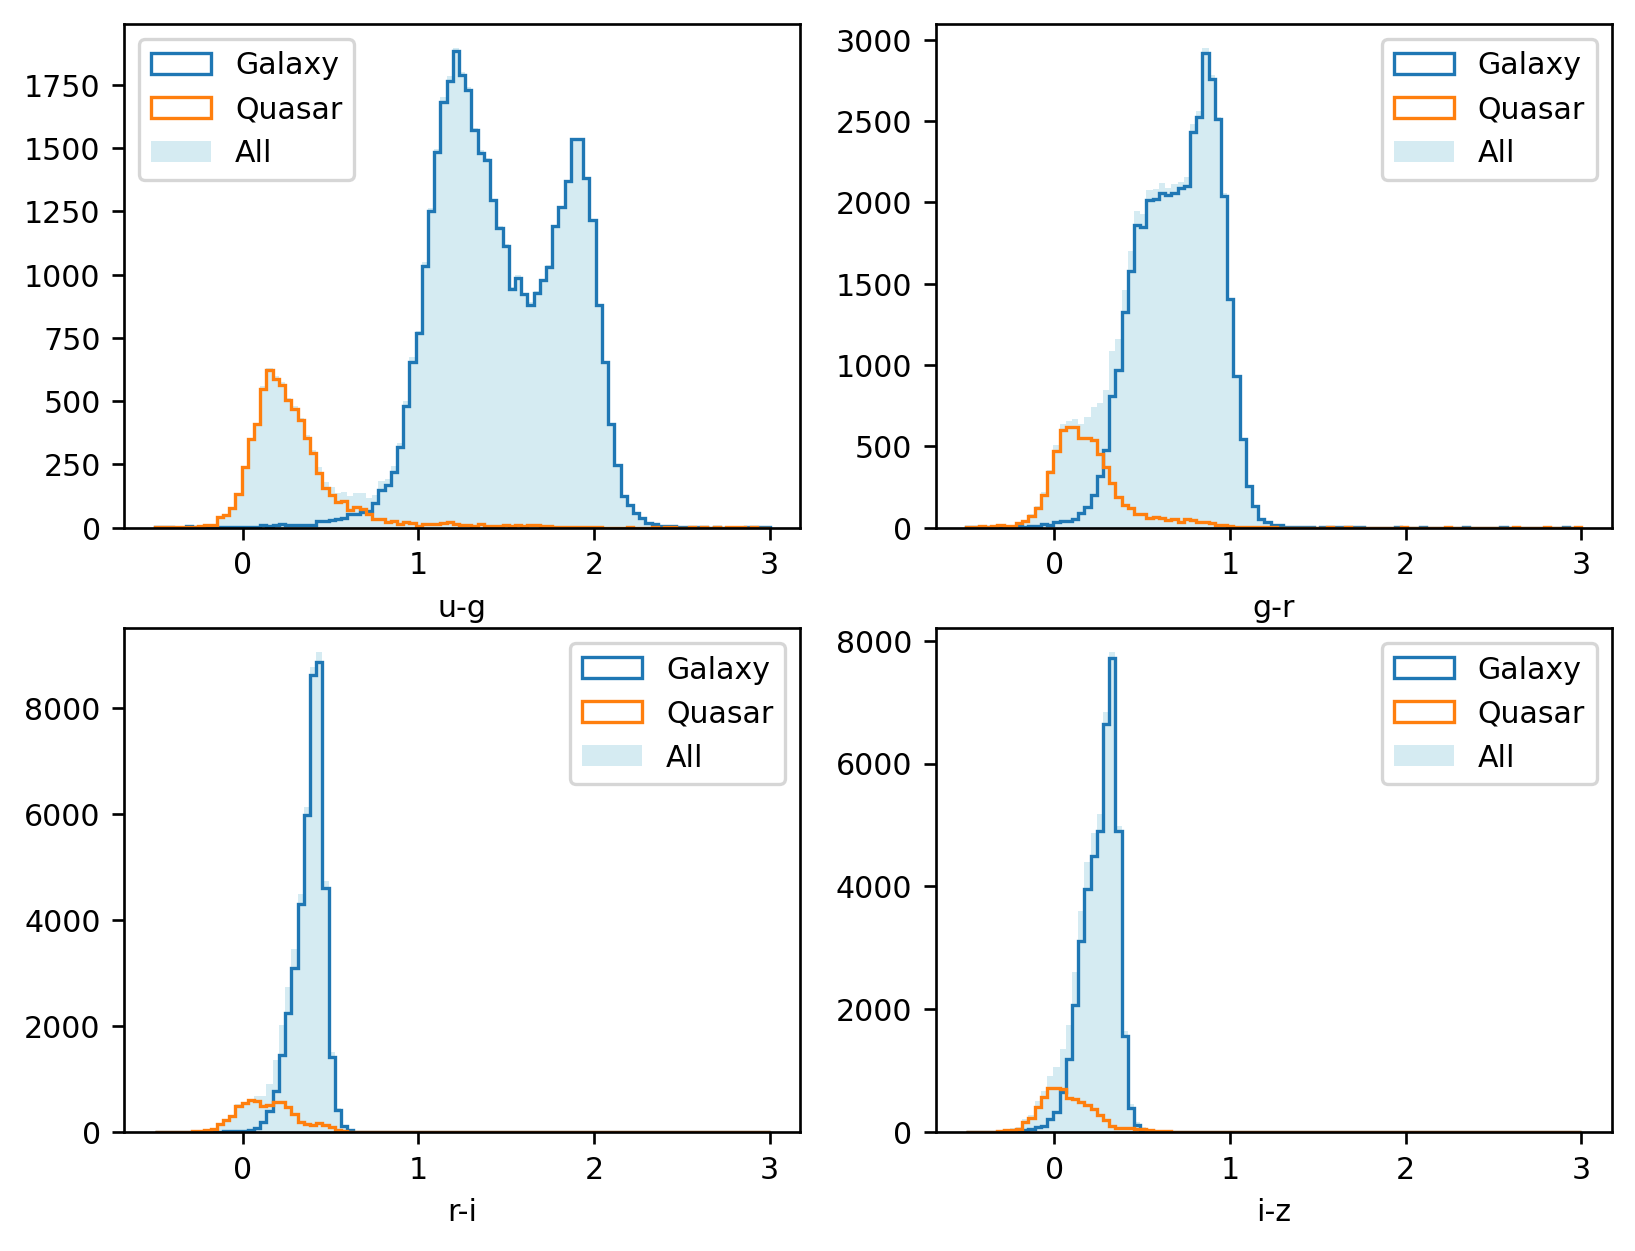

In [5]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

bins = np.linspace(-0.5, 3, 100)

for ax,color, name in zip(axs.flatten() ,data[:,:4].T,names):
    ax.hist(color[lab==0], bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(color[lab==1], bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    
plt.tight_layout;

From color distributions it seems that u-g is by far the most informative feature as it shows a clear bimodality differentiating galaxies and quasars. For the other colors, quasars only create a small bump in the total distribution.

In [6]:
# Train and test sets

X = data
y = lab
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=0)


In [7]:
# Fit all the models to the training data

def compute_models(*args):
    names = []
    probs = []
    preds = []
    completeness = []
    contamination = []
    accuracy = []
    classifiers = []
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        classifiers.append(clf)
        y_probs = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        complet = recall_score(y_test, y_pred)
        contam = 1 - precision_score(y_test, y_pred)
        accur = accuracy_score(y_test, y_pred)
        
        names.append(classifier.__name__)
        probs.append(y_probs)
        preds.append(y_pred)
        completeness.append(float(complet))
        contamination.append(float(contam))
        accuracy.append(accur)


    return names, probs, preds, completeness, contamination, accuracy, classifiers

names, probs, preds, completeness, contamination, accuracy, classifiers = \
    compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=6)),
                              (GMMBayes, dict(n_components=5, tol=1E-5,
                                              covariance_type='full')))
    # , tol=1E-5

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


We can compare the different classifiers computing descriptive metrics and plotting ROC curves and precision - recall curves:

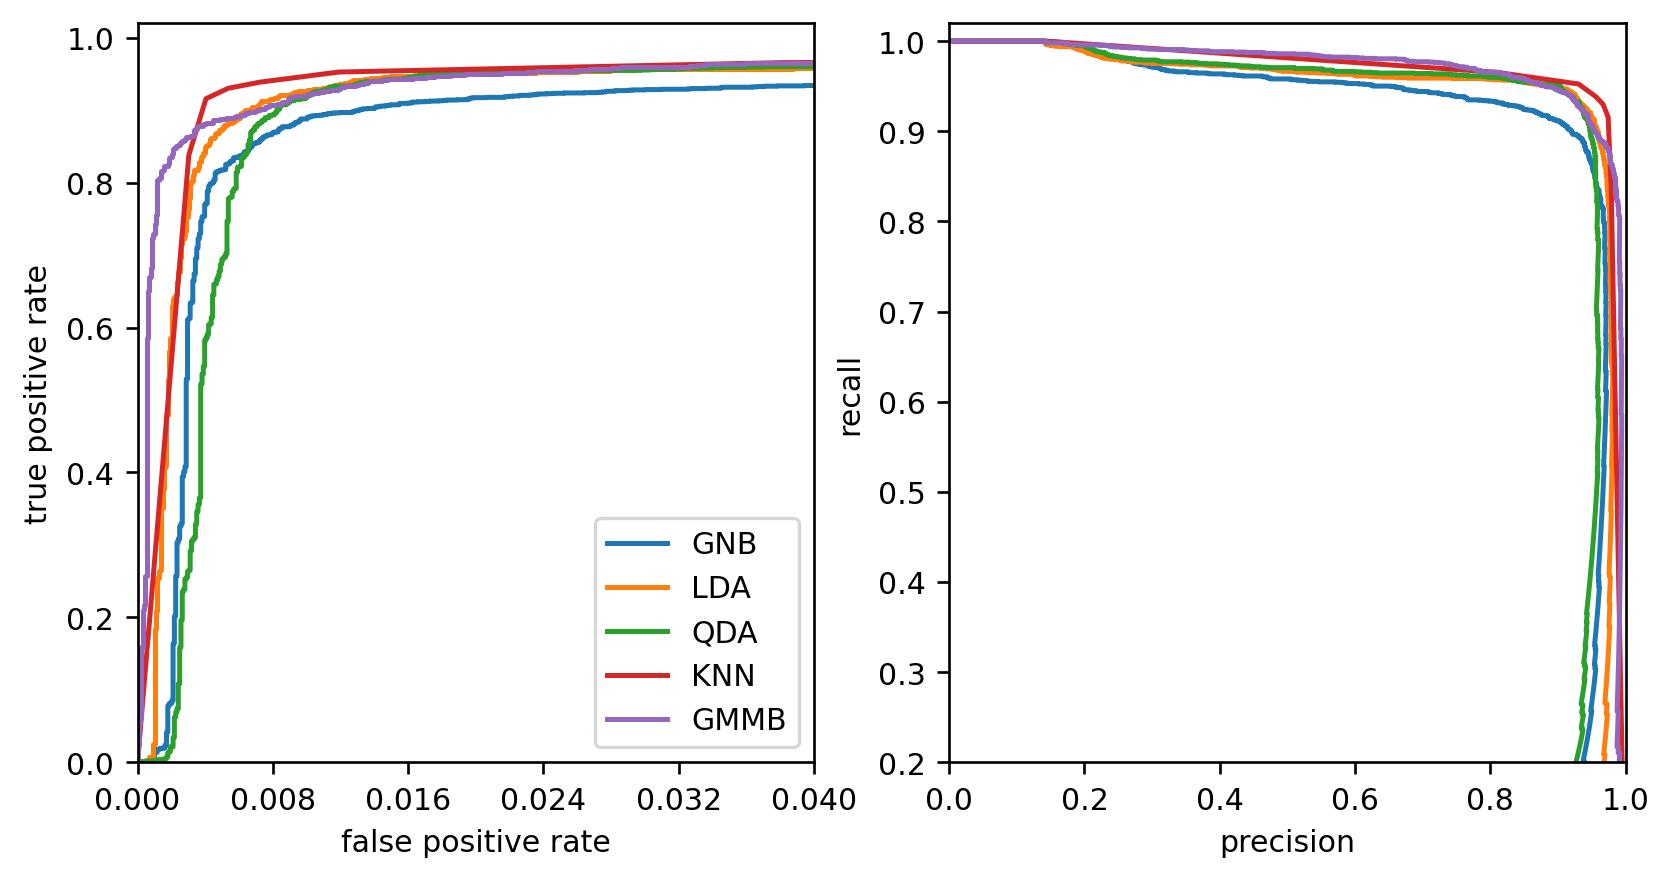

In [13]:
labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              GMMBayes='GMMB')

#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig = plt.figure()

# ROC curves
ax1 = fig.add_subplot(121)
# precision recall curves
ax2 = fig.add_subplot(122)

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    # thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])
    ax2.plot(precision, recall, label=labels[name])
    
ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('precision')
ax2.set_ylabel('recall')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02);



In [16]:
# Print results
   
print("{:<30} {:<20} {:<20} {:<20}".format('names','completeness', 'contamination', 'accuracy'))
for name, complet, contam, acc in zip(names,completeness,contamination,accuracy):
    print("{:<30} {:<20.3f} {:<20.3f} {:<20.3f}".format(name, complet, contam, acc))

names                          completeness         contamination        accuracy            
GaussianNB                     0.918                0.122                0.970               
LinearDiscriminantAnalysis     0.925                0.057                0.981               
QuadraticDiscriminantAnalysis  0.927                0.067                0.980               
KNeighborsClassifier           0.930                0.033                0.985               
GMMBayes                       0.931                0.054                0.982               


We tune K-neighbors with Cross-validation:

In [13]:
from sklearn.model_selection import GridSearchCV
kvals = np.arange(1,10, 1)
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kvals}, cv = 10)
grid.fit(X_train, y_train)
best_k = grid.best_params_['n_neighbors']
print(f'Best K = {best_k}')

Best K = 6


In [29]:
clf = KNeighborsClassifier(6)
clf.fit(X_train,y_train)

y_probs = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
complet = recall_score(y_test, y_pred)
contam = 1 - precision_score(y_test, y_pred)
accur = accuracy_score(y_test, y_pred)

print("{:<30} {:<20} {:<20} {:<20}".format('names','completeness', 'contamination', 'accuracy'))
print("{:<30} {:<20.3f} {:<20.3f} {:<20.3f}".format('KNeighborsClassifier', complet, contam, accur))


names                          completeness         contamination        accuracy            
KNeighborsClassifier           0.930                0.033                0.985               


Does not change much in the interval 3<k<10.

The best performing classifier is KNeighbors, the worst is Naive Bayes. Let's see how they manage with different color subsets:
- Only with u-g (most informative)
- Only with i-z (least informative)
- Adding other colors to u-g to see if classification performance is enhanced


In [114]:
def compute_models_new(xtrain, xtest, *args):
    names = []
    probs = []
    preds = []
    completeness = []
    contamination = []
    accuracy = []
    classifiers = []
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(xtrain, y_train)
        
        classifiers.append(clf)
        y_probs = clf.predict_proba(xtest)[:, 1]
        y_pred = clf.predict(xtest)
        complet = recall_score(y_test, y_pred)
        contam = 1 - precision_score(y_test, y_pred)
        accur = accuracy_score(y_test, y_pred)
        
        names.append(classifier.__name__)
        probs.append(y_probs)
        preds.append(y_pred)
        completeness.append(float(complet))
        contamination.append(float(contam))
        accuracy.append(accur)


    return completeness, contamination, accuracy, preds


In [115]:
data_list = []

# Only u-g
xtrain = X_train[:,0][:,None]
xtest = X_test[:,0][:,None]
data_list.append([xtrain,xtest])

# Only i-z
xtrain = X_train[:,3][:,None]
xtest = X_test[:,3][:,None]
data_list.append([xtrain,xtest])

# U-g adding all other colors in sequence
for i in range(1,4):
    xtrain = X_train[:,:i]
    xtest = X_test[:,:i]
    data_list.append([xtrain,xtest])


In [129]:
# These lists store results for different combinations, with dimensions (5,2)
complet_list = []
contam_list = []
accu_list = []
pred_list = []

for data in data_list:
    completeness, contamination, accuracy, predictions = \
        compute_models_new(data[0], data[1], (GaussianNB, {}), (KNeighborsClassifier, dict(n_neighbors=6)))
    
    complet_list.append(completeness)
    contam_list.append(contamination)
    accu_list.append(accuracy)
    pred_list.append(predictions)
    
complet_arr = np.array(complet_list).T
contam_arr = np.array(contam_list).T
accu_arr = np.array(accu_list).T
clf_arr = np.array(clf_list).T

metrics_list = [accu_arr, complet_arr, contam_arr]
names = ['accuracy', 'recall / completeness', 'contamination']

GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier


/home/fra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier


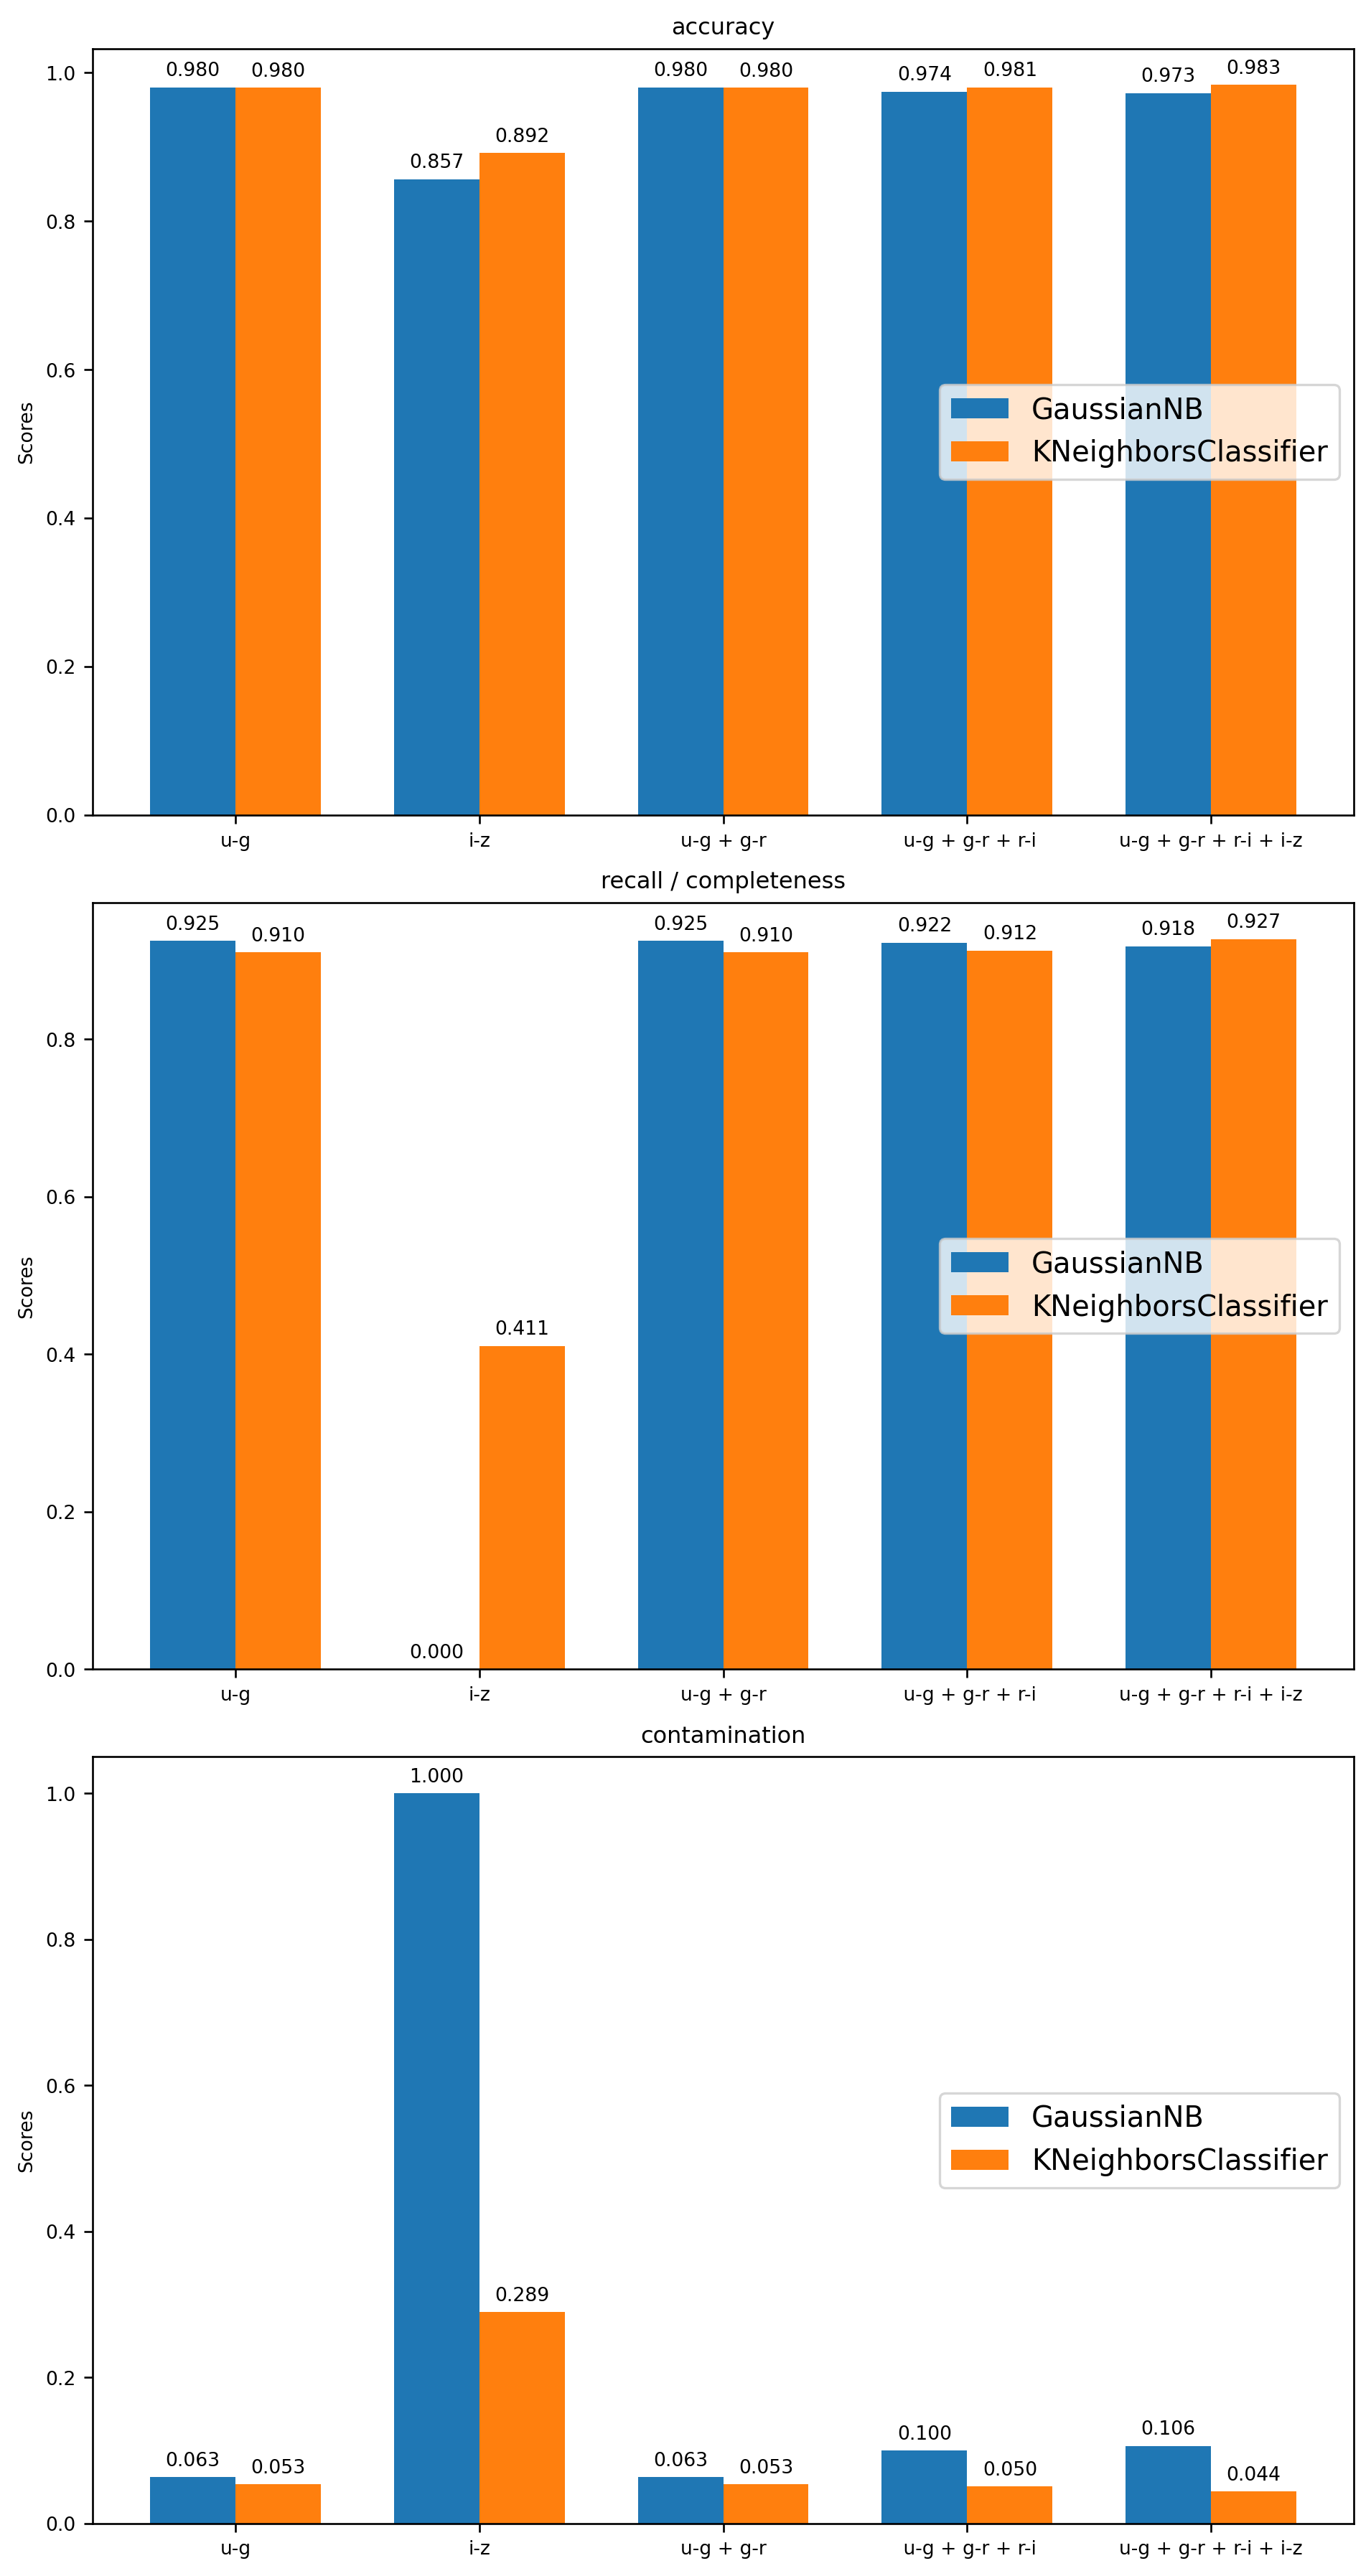

In [131]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,15), dpi=120)
plt.rcParams.update({'font.size': 8})
#--------------------------------------------

labels = ['u-g', 'i-z', 'u-g + g-r',' u-g + g-r + r-i', 'u-g + g-r + r-i + i-z']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Accuracy

fig, axs = plt.subplots(3,1)

for ax,metric,name in zip(axs.flatten(), metrics_list, names):
    
    rects1 = ax.bar(x - width/2, metric[0], width, label='GaussianNB')
    rects2 = ax.bar(x + width/2, metric[1], width, label='KNeighborsClassifier')

    ax.set_ylabel('Scores')
    ax.set_title(name)
    ax.set_xticks(x, labels)

    ax.legend(loc='center right', fontsize=12)

    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

In [128]:
# Control to see what happens for i-z classification with NaiveBayes
n_galax = len(y_test[y_test == 0])
n_quas = len(y_test[y_test == 1])
n_tot = len(y_test)

print(n_galax, n_quas)
print(n_galax/n_tot)

12852 2148
0.8568


Using only i-z feature:
- NaiveBayes classifier counts everything as a galaxy. As the number of quasars is much lower, accuracy is not a great metric to measure classification performance: we see from completeness and contamination that the classification has failed.
- K-Neighbors is able to do a classification of sources, though we can see that completeness and contamination indicate a poor performance.

About the "Naive assumption" of feature independence:
- Colors are clearly not independent as they are linear combinations of common measured features.
- NaiveBayes is impacted from this fact, as we can see that it obtains the highest accuracy score using only the u-g feature, and gets worse adding more features.
- K-Neighbors on the contrary performs better when adding more features.